In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os
from moviepy.editor import VideoFileClip
from IPython.display import display
import glob
import pickle
import ipywidgets
import math
import json
import os.path
%matplotlib inline

In [2]:
def rgb_to_8_bit_gray(im):
    im_gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
    im_gray = (im_gray*(np.max(im_gray)-np.min(im_gray))*255 ).astype('uint8')
    return im_gray

In [6]:
def reprojection_error(obj_points, img_points, camera_matrix, dist_coeffs, rvecs, tvecs ):
    obj_points = np.array(obj_points)
    rvecs = np.array(rvecs)
    tvecs = np.array(tvecs)
    tot_error=0
    total_points=0
    for i in range(len(obj_points)):
        reprojected_points, _ = cv2.projectPoints(obj_points[i], rvecs[i], tvecs[i], camera_matrix, dist_coeffs)
        #reprojected_points=reprojected_points.reshape(-1,2)
        this_error = np.sum(np.abs(img_points[i]-reprojected_points)**2)
        this_count = len(img_points[i])
        #print('individual error:',np.sqrt(this_error/this_count))
        tot_error+=this_error
        total_points+=this_count

    mean_error=np.sqrt(tot_error/total_points)
    return mean_error

In [15]:
def stereo_calibrate(left_image_paths, right_image_paths):
    if len(left_image_paths) != len(right_image_paths):
        raise ValueError('left and right images lists must be the same length')
    w=9
    h=6
    pattern_size = (w,h)
    pattern_square_meters = 0.02349


    # termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.1)

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    single_object_points = np.zeros((w*h,3), np.float32)
    single_object_points[:,:2] = np.mgrid[0:w,0:h].T.reshape(-1,2) * pattern_square_meters

    OP = []
    IP1 = []
    IP2 = []
    dpix = None
    im_shape = None

    for left_image_path, right_image_path in list(zip(left_image_paths, right_image_paths)):
        left_image = plt.imread(left_image_path)
        left_image_gray = rgb_to_8_bit_gray(left_image)
        right_image = plt.imread(right_image_path)
        right_image_gray = rgb_to_8_bit_gray(right_image)

        if im_shape is None:
            im_shape = left_image_gray.shape[::-1]
        if left_image_gray.shape[::-1] != im_shape:
            raise( ValueError('image different shape: '+ left_image_path))
        if right_image_gray.shape[::-1] != im_shape:
            raise( ValueError('image different shape: '+ right_image_path))
        found,left_corners = cv2.findChessboardCorners(left_image_gray, pattern_size, None)
        if found==False:
            print("Can't find corners for",left_image_path)
            continue
        found,right_corners = cv2.findChessboardCorners(right_image_gray, pattern_size, None)
        if found==False: 
            print("Can't find corners for",right_image_path)
            continue

        # subpix corner matching
        if dpix is None:
            dpix = im_shape[0]//120 * 2 + 1 # generates an odd number based on image size
            #dpix = 11
            print('dpix', dpix)
        left_corners = cv2.cornerSubPix(left_image_gray,left_corners,(dpix,dpix),(-1,-1),criteria)
        right_corners = cv2.cornerSubPix(right_image_gray,right_corners,(dpix,dpix),(-1,-1),criteria)
        
        if False:
            cv2.drawChessboardCorners(left_image, pattern_size, left_corners, True)
            cv2.drawChessboardCorners(right_image, pattern_size, right_corners, True)

            fig = plt.figure()
            fig.set_size_inches(w=15,h=15)
            plt.subplot(1,2,1)
            plt.imshow(left_image)
            plt.subplot(1,2,2)
            plt.imshow(right_image)
            plt.close()
            display(fig)
            


        IP1.append(left_corners)
        IP2.append(right_corners)
        OP.append(single_object_points)
    cx=im_shape[0]/2.
    cy=im_shape[1]/2.

    # set initial guess for camera matrix
    M1 = np.array([ [1,0,cy], [0,1,cx], [0,0,1]])
    M2 = np.array([ [1,0,cy], [0,1,cx], [0,0,1]])

    print('cx,cy',(cx,cy))
    ret, M1, D1, rvecs, tvecs = cv2.calibrateCamera(
        OP, 
        IP1, 
        im_shape, 
        M1,
        distCoeffs = None,
        flags = cv2.CALIB_FIX_ASPECT_RATIO)# | cv2.CALIB_FIX_PRINCIPAL_POINT)
    print('IP1 reprojection error ret:',ret)
    print('reprojection_error calc:', reprojection_error(OP,IP1,M1,D1,rvecs,tvecs))

    ret, M2, D2, rvecs, tvecs = cv2.calibrateCamera(
        OP,
        IP2, 
        im_shape, 
        M2,
        distCoeffs = None,
        flags = cv2.CALIB_FIX_ASPECT_RATIO )#| cv2.CALIB_FIX_PRINCIPAL_POINT)
    print('IP2 reprojection error:',ret)
    print('reprojection_error calc:', reprojection_error(OP,IP2,M2,D2,rvecs,tvecs))
    
    print("M1",M1)
    print("M2",M2)
    



    retval, M1, D1, M2, D2, R, T, E, F  = cv2.stereoCalibrate(OP, IP1, IP2, M1, D1, M2, D2, im_shape, flags=cv2.CALIB_SAME_FOCAL_LENGTH| cv2.CALIB_ZERO_TANGENT_DIST)
    R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(M1, D1, M2, D2, im_shape, R, T, alpha=.0)#, flags=cv2.CALIB_ZERO_DISPARITY)
    print('roi2',roi2)
    print('P1',P1)

    map1x, map1y = cv2.initUndistortRectifyMap(M1, D1, R1, P1, im_shape, cv2.CV_16SC2) #P1 was M1
    map2x, map2y = cv2.initUndistortRectifyMap(M2, D2, R2, P2, im_shape, cv2.CV_16SC2) #P2 was M2
    
    for i in range(len(left_image_paths))[0:3]:
        left_image = plt.imread(left_image_paths[i])
        right_image = plt.imread(right_image_paths[i])

        if True:
            ul = cv2.undistort(left_image, M1, D1);
            ur = cv2.undistort(right_image, M2, D2);

            fig = plt.figure()
            fig.set_size_inches(w=15,h=15)
            plt.subplot(1,2,1)
            plt.imshow(ul)
            plt.subplot(1,2,2)
            plt.imshow(ur)
            plt.close()
            display(fig)
        
        left_image_fixed = cv2.remap(left_image, map1x, map1y, cv2.INTER_LINEAR)
        right_image_fixed = cv2.remap(right_image, map2x, map2y, cv2.INTER_LINEAR)

        #stereo = cv2.StereoBM_create(numDisparities=256, blockSize=25)
        stereo = cv2.StereoSGBM_create(minDisparity = 0,numDisparities=256, blockSize=25, P1=75, P2=150)

        left_gray = rgb_to_8_bit_gray(left_image_fixed)
        right_gray = rgb_to_8_bit_gray(right_image_fixed)

        #left_blur = cv2.GaussianBlur(left_gray,(5,5),0)
        #right_blur = cv2.GaussianBlur(right_gray,(5,5),0)
        disparity = stereo.compute(left_gray, right_gray)
        cmap = 'magma'
        #cmap = 'gray'
        fig = plt.figure()
        print(os.path.basename(left_image_paths[i]))
        fig.set_size_inches(w=16,h=5)
        plt.subplot(1,3,1)
        plt.imshow(left_image_fixed)
        plt.subplot(1,3,2)
        plt.imshow(right_image_fixed)
        plt.subplot(1,3,3)
        plt.imshow(disparity,cmap=cmap)
        plt.close()
        display(fig)



    return D1, M1, D2, M2, R, T, E, F

processing elp1 320_240_d
dpix 5
cx,cy (160.0, 120.0)
IP1 reprojection error ret: 0.1906274996384436
reprojection_error calc: 0.190627446189
IP2 reprojection error: 0.1847956557618069
reprojection_error calc: 0.184795737928
M1 [[ 240.9549        0.          153.87731831]
 [   0.          240.9549      119.60512783]
 [   0.            0.            1.        ]]
M2 [[ 238.84022494    0.          159.97917648]
 [   0.          238.84022494  121.20606424]
 [   0.            0.            1.        ]]
roi2 (0, 0, 0, 0)
P1 [[  2.22952613e+03   0.00000000e+00   3.58587738e+02   0.00000000e+00]
 [  0.00000000e+00   2.22952613e+03   1.50988971e+01   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00]]


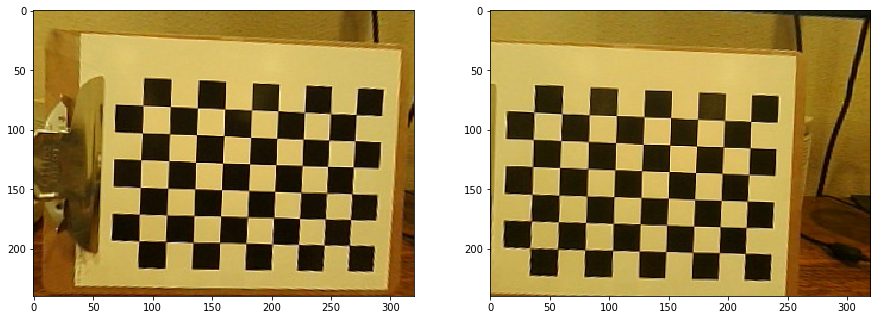

cap_2017-10-03T21.06.04.194_left.png


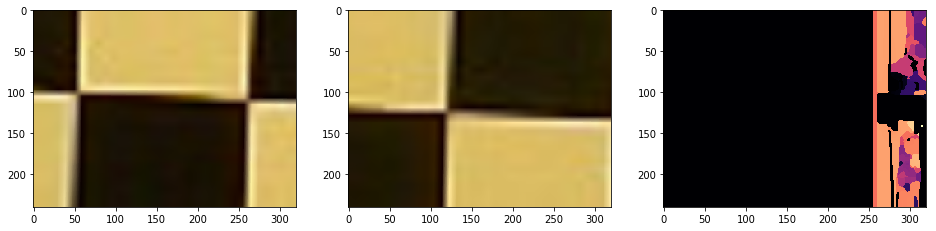

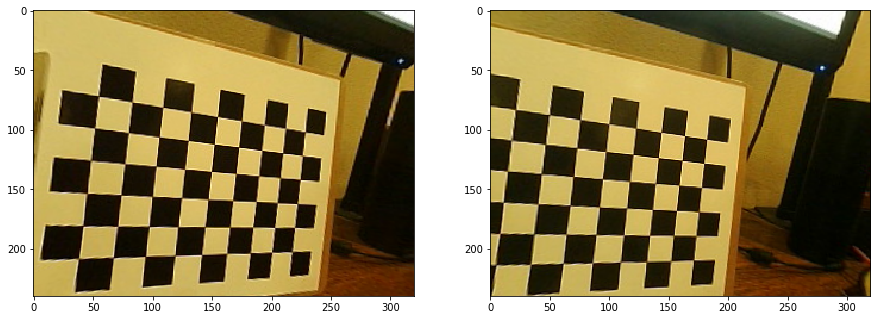

cap_2017-10-03T21.06.24.008_left.png


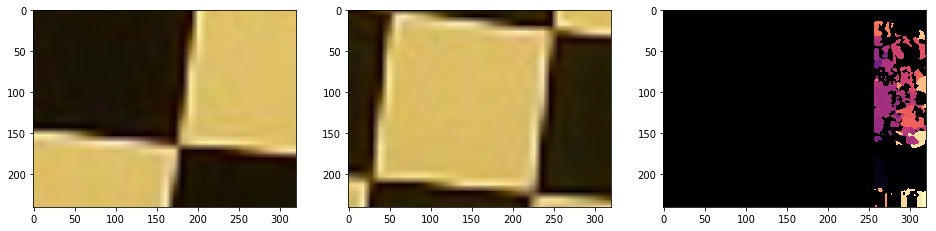

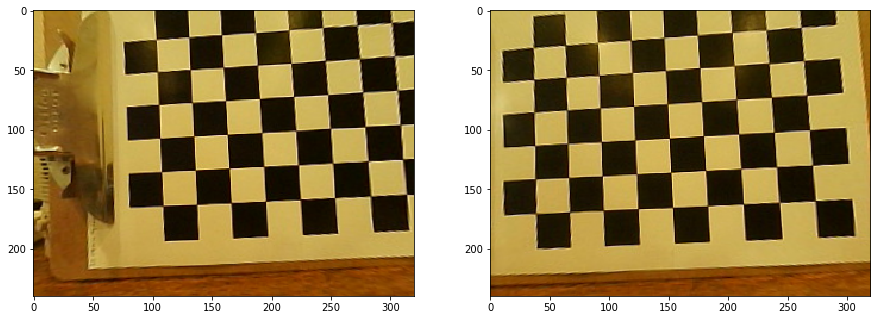

cap_2017-10-03T21.07.02.830_left.png


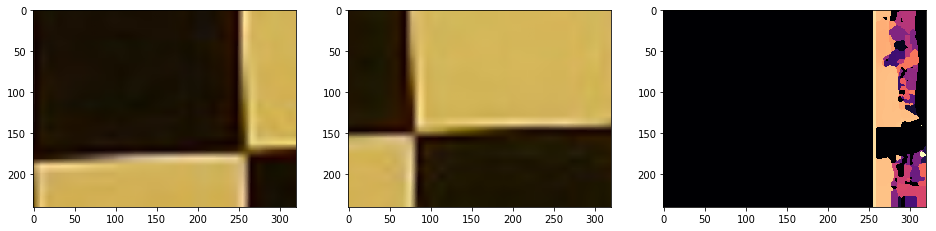

In [16]:
# stereo calibration of left and right images

chessboard_paths = sorted(glob.glob('input/chessboard_images/stereo/*'))
all_calibrations = dict()
for chessboard_path in sorted(chessboard_paths):
    camera_name = os.path.basename(chessboard_path)
    for resolution_path in glob.glob(chessboard_path + "/*"):
        resolution_name = os.path.basename(resolution_path)
        if resolution_name != '320_240_d': continue
        print('processing',camera_name,resolution_name)
        
        left_image_paths = sorted(glob.glob(resolution_path+'/*left.png'))
        right_image_paths = sorted(glob.glob(resolution_path+'/*right.png'))
        stereo_calibrate(left_image_paths, right_image_paths)